# Variance Invesigation using PDF

This investigation uses the PDF of the SPE distribution to investigate the gain and variance insteraction

In [17]:
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import polyfit, polyval
from numba import njit, prange, vectorize, int64, float64
from math import lgamma, exp, pow, sqrt, log, pi
from functools import partial
from scipy.stats import poisson
from scipy.signal import convolve
from matplotlib import pyplot as plt
from tqdm import trange, tqdm
%matplotlib inline

In [18]:
SQRT2PI = sqrt(2.0 * pi) 

@vectorize([float64(float64, float64, float64)], fastmath=True)
def normal_pdf(x, mean=0, std_deviation=1):
    u = (x - mean) / std_deviation
    return exp(-0.5 * u ** 2) / (SQRT2PI * std_deviation)

@vectorize([float64(int64, float64)], fastmath=True)
def poisson_pmf(k, mu):
    return exp(k * log(mu) - mu - lgamma(k + 1))

@vectorize([float64(int64, int64)], fastmath=True)
def binom(n, k):
    return exp(lgamma(n + 1) - lgamma(k + 1) - lgamma(n - k + 1))

In [19]:
@njit(fastmath=True, parallel=True)
def pmt_spe(x, eped, eped_sigma, spe, spe_sigma, lambda_):    
    # Obtain pedestal peak
    p_ped = exp(-lambda_)
    pe_signal = p_ped * normal_pdf(x, eped, eped_sigma)


    # Loop over the possible total number of cells fired
    found = False
    for k in prange(1, 250):
        p = poisson_pmf(k, lambda_)  # Probability to get k avalanches

        # Skip insignificant probabilities
        if (not found) & (p < 1e-4):
            continue
        if found & (p < 1e-4):
            break
        found = True

        pe_sigma = sqrt(k * spe_sigma ** 2 + eped_sigma ** 2)
        pe_signal += p * normal_pdf(x, eped + k * spe, pe_sigma)

    return pe_signal

In [20]:
@njit(fastmath=True, parallel=True)
def sipm_spe(x, eped, eped_sigma, spe, spe_sigma, lambda_, opct):
    # Obtain pedestal peak
    p_ped = exp(-lambda_)
    pe_signal = p_ped * normal_pdf(x, eped, eped_sigma)

    # Loop over the possible total number of cells fired
    found = False
    for k in prange(1, 250):
        pk = 0
        for j in prange(1, k+1):
            pj = poisson_pmf(j, lambda_)  # Probability for j initial fired cells

            # Skip insignificant probabilities
            if pj < 1e-4:
                continue

            # Sum the probability from the possible combinations which result
            # in a total of k fired cells to get the total probability of k
            # fired cells
            pk += pj * pow(1-opct, j) * pow(opct, k-j) * binom(k-1, j-1)
            
        # Skip insignificant probabilities
        if (not found) & (pk < 1e-4):
            continue
        if found & (pk < 1e-4):
            break
        found = True
        
        pe_sigma = sqrt(k * spe_sigma ** 2 + eped_sigma ** 2)
        pe_signal += pk * normal_pdf(x, eped + k * spe, pe_sigma)

    return pe_signal

In [34]:
# PMT SES Definition
@njit(fastmath=True, parallel=True)
def pmt_ses(x, spe, spe_sigma):
    pe_sigma = sqrt(spe_sigma ** 2)
    pe_signal = normal_pdf(x, spe, pe_sigma)
    return pe_signal

In [35]:
# SiPM SES Definition
@vectorize([float64(float64, float64, float64, float64)], fastmath=True)
def sipm_ses(x, spe, spe_sigma, opct):
    pe_signal = 0
    # Loop over the possible total number of cells fired
    for k in range(1, 250):
        pk = (1-opct) * pow(opct, k-1)

        # Combine spread of pedestal and pe (and afterpulse) peaks
        pe_sigma = np.sqrt(k * spe_sigma ** 2)

        # Evaluate probability at each value of x
        pe_signal += pk * normal_pdf(x, k * spe, pe_sigma)

    return pe_signal

Text(0.5, 1.0, 'SES (ylog)')

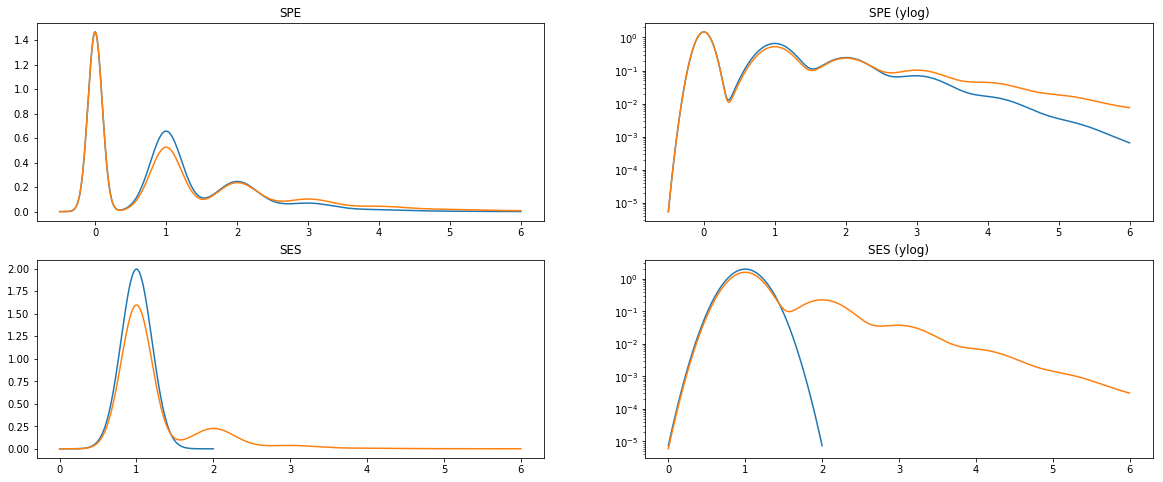

In [206]:
# Define input parameters
eped = 0
eped_sigma = 0.1
spe = 1
spe_sigma = 0.2
opct = 0.2

# Demonstrate SPE
n_pe = 1
f, ((a0, a1), (a2, a3)) = plt.subplots(2, 2, figsize=(20, 8))

x_pmt = np.linspace(-0.5, 6, 10000)
pdf_pmt = pmt_spe(x_pmt, eped, eped_sigma, spe, spe_sigma, n_pe)

x_sipm = np.linspace(-0.5, 6, 10000)
pdf_sipm = sipm_spe(x_sipm, eped, eped_sigma, spe, spe_sigma, n_pe, opct)

a0.plot(x_pmt, pdf_pmt)
a0.plot(x_sipm, pdf_sipm)
a1.semilogy(x_pmt, pdf_pmt)
a1.semilogy(x_sipm, pdf_sipm)

# Demonstrate SES

x_pmt = np.linspace(0, 2, 10000)
pdf_pmt = pmt_ses(x_pmt, spe, spe_sigma)

x_sipm = np.linspace(0, 6, 10000)
pdf_sipm = sipm_ses(x_sipm, spe, spe_sigma, opct)

a2.plot(x_pmt, pdf_pmt)
a2.plot(x_sipm, pdf_sipm)
a3.semilogy(x_pmt, pdf_pmt)
a3.semilogy(x_sipm, pdf_sipm)

a0.set_title("SPE")
a1.set_title("SPE (ylog)")
a2.set_title("SES")
a3.set_title("SES (ylog)")

## PMT

100%|██████████| 49/49 [00:00<00:00, 97.13it/s] 


(y = 2.23x + 0.20)
Difference between gain approaches: 0.9975862084533096
Difference between variance slope calculations: 0.9956481026280452


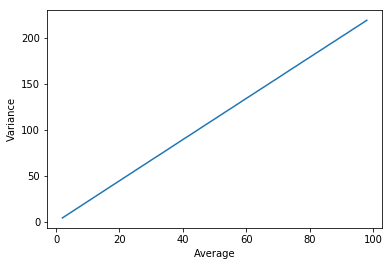

In [200]:
# Define input parameters
eped = 0
eped_sigma = 0.3
spe = 2
spe_sigma = 0.7

x = np.linspace(-10, 500, 100000)
n_pe_array = np.arange(1, 50)
d_list = []
for n_pe in tqdm(n_pe_array):
    y = pmt_spe(x, eped, eped_sigma, spe, spe_sigma, n_pe)
    
    average = np.average(x, weights=y)
    variance = np.average((x-average)**2, weights=y)
    
    d_list.append(dict(
        n_pe=n_pe,
        average=average,
        variance=variance,
    ))
    
df = pd.DataFrame(d_list)

x = df['average']
y = df['variance']
c = polyfit(x, y, 1)
print(f"(y = {c[1]:.2f}x + {c[0]:.2f})")
plt.plot(x, y)
plt.xlabel("Average")
plt.ylabel("Variance")

intercept_0 = c[0]
slope_0 = c[1]

ses_x = np.linspace(0, 100, 1000)
ses_pdf = pmt_ses(ses_x, spe, spe_sigma)
ses_average = np.average(ses_x, weights=ses_pdf)
ses_variance = np.average((ses_x-ses_average)**2, weights=ses_pdf)
ses_std = np.sqrt(ses_variance)

g_spe = (df['average'] / df['n_pe']).iloc[0]
g_ses = ses_average
print(f"Difference between gain approaches: {g_spe / g_ses}")

slope_1 = g_ses * (1 + (ses_std/ses_average)**2)
print(f"Difference between variance slope calculations: {slope_0 / slope_1}")

## SiPM

100%|██████████| 49/49 [00:00<00:00, 65.79it/s] 


(y = 3.22x + 0.45)
Difference between gain approaches: 0.9975487797907294
Difference between variance slope calculations: 0.9912078948715513


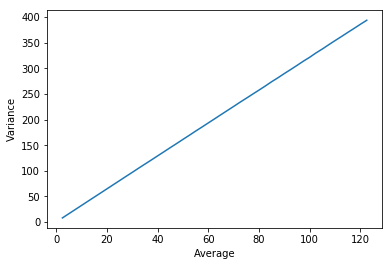

In [204]:
# Define input parameters
eped = 0
eped_sigma = 0.3
spe = 2
spe_sigma = 0.7
opct = 0.2

x = np.linspace(-10, 500, 100000)
n_pe_array = np.arange(1, 50)
d_list = []
for n_pe in tqdm(n_pe_array):
    y = sipm_spe(x, eped, eped_sigma, spe, spe_sigma, n_pe, opct)
    
    average = np.average(x, weights=y)
    variance = np.average((x-average)**2, weights=y)
    
    d_list.append(dict(
        n_pe=n_pe,
        average=average,
        variance=variance,
    ))
    
df = pd.DataFrame(d_list)

x = df['average']
y = df['variance']
c = polyfit(x, y, 1)
print(f"(y = {c[1]:.2f}x + {c[0]:.2f})")
plt.plot(x, y)
plt.xlabel("Average")
plt.ylabel("Variance")

intercept_0 = c[0]
slope_0 = c[1]

ses_x = np.linspace(0, 100, 1000)
ses_pdf = sipm_ses(ses_x, spe, spe_sigma, opct)
ses_average = np.average(ses_x, weights=ses_pdf)
ses_variance = np.average((ses_x-ses_average)**2, weights=ses_pdf)
ses_std = np.sqrt(ses_variance)

g_spe = (df['average'] / df['n_pe']).iloc[0]
g_ses = ses_average
print(f"Difference between gain approaches: {g_spe / g_ses}")

slope_1 = g_ses * (1 + (ses_std/ses_average)**2)
print(f"Difference between variance slope calculations: {slope_0 / slope_1}")